<div style="font-family: 'Times New Roman'; font-size: 16px;">

# Quantum Linear Algebra
The Harrow–Hassidim–Lloyd (HHL) algorithm [Project 1]  
*By Sonny Lowe, David Lee, Arav Raval*

</div>


<div style="font-family: 'Times New Roman'; font-size: 16px;">

This notebook will discuss the Harrow-Hassidim-Lloyd (HHL) quantum algorithm, meant for solving a linear system
$$A\vec{x}=\vec{b} \text{ ,  where } A \text{ is a hermitian matrix}$$
and where $\vec{x}$ and $\vec{b}$ ultimately represent quantum states $\ket{x}$ and $\ket{b}$ respectively. We will provide a derivation, implementation, generalization to non-hermitian matrices, as well as the context for HHL as a subroutine.

Note: we will generally be working in the normalized domain.
</div>

<div style="font-family: 'Times New Roman'; font-size: 16px;">

### Section 1: Mathematical Derivation
 
Our problem is represented as 
$$A\ket{x} = \ket{b}$$
where $\ket{b} \in \mathbb{C}^N$ is some given quantum state and $A \in \mathbb{C}^{N\times N}$. Our goal is to solve for $\ket{x} \in \mathbb{C}^N$ under a few conditions:
- $A$ is hermitian such that $A = A^\dagger$
- $A$ is $s$-sparse and well conditioned, meaning it has at most $s$ nonzero entries per row and its condition number  $\kappa(A)$ is relatively small such that the system is stable and less sensitive to perturbations.
We will break down the derivation into several steps.
- We have access to an "oracle" of A in that we have its eigenvalues to use in our circuit (potential weakness).
- We assume there exists some efficient algorithm to prepare $\ket{b}$

<br>

#### **1. Rewriting and Initialization**
Given that $A$ is a hermitian matrix, there exists a spectral decomposition such that the matrix can be diagonalized by unitary transformations.
$$A = UDU^T,\quad \text{ where } U \text{ is a unitary matrix and } D \text{ is diagonal composed of the real eigenvalues of } A$$
Since the columns of $U$ form an orthonormal basis and are the eigenvalues, we can rewrite this decomposition where $\ket{u_{j}}$ is the $j^{th}$ eigenvector of $A$ with respective eigenvalue $\lambda_{j}$ as:
$$A = \sum_{i=0}^{N-1}\lambda_{i}\ket{u_{i}}\bra{u_{i}}, \quad \lambda_{i}\in\mathbb{ R }$$
Likewise, as a linear transformation, we can write our resultant vector $\ket{b}$ in the eigenbasis of $A$.
$$\ket{b} = \sum_{i=0}^{N-1}b_{i}\ket{u_{i}}, \quad b_{i}\in\mathbb{ C }$$
Thus, our problem can now be rewritten as:
$$\ket{x} = A^{-1}\ket{b} = \sum_{i=0}^{N-1}\frac{1}{\lambda_{i}}b_{i}\ket{u_{i}}\bra{u_{i}}u_{i}\rangle = \sum_{i=0}^{N-1}\frac{1}{\lambda_{i}}b_{i}\ket{u_{i}}$$

Moreover, note that to represent a state vector $\ket{b}$ of dimension $N$, to prepare it as a quantum register, we prepare it in binary basis using $\log_2{N}$ qubits. Therefore, from here on, $N = \log_2{N}$.

<br>

#### **2. Quantum Phase Estimation**
The problem first boils down to being able to decompose a matrix to find its eigenvalues and eigenvectors in a computationally efficient manner. At a high level, Quantum Phase Estimation is a procedure that performs a series of controlled-$U$ gates given some unitary matrix $U$ with eigenvalues of the form $e^{2\pi i \theta}$, and finds the phase $\theta$.

The number of qubits required for QPE is defined by the required additive error epsilon $\epsilon$, where we will set $n_q = O(\log{\frac{1}{\epsilon}})$ representing the number of qubits needed.

For HHL, first, we start with two registers $\ket{0}^{\otimes n_q}$ and $\ket{b}$. Our initial state is thus $\ket{\Phi_0} = \ket{0}^{\otimes n_q} \otimes \ket{b}.$ Then we can characterize the behavior of **QPE** as:
$$\textbf{QPE}(U,\ket{0}^{\otimes n_q},\ket{b}) = \textbf{QPE}(U,\ket{0}^{\otimes n_q},\sum_{j=0}^{N-1}b_{j}\ket{u_{j}}) = \sum_{j=0}^{N-1}b_{j} \ket{\tilde{\lambda_{j}}}_{n_q}  \ket{u_{j}}, \quad\text{ for some clever choice of } U$$

We will choose $U = e^{iAt}$ for some constant $t$ such that $U$ is governed by the same eigenvalues of $A$ and we have that, where $\ket{u_{j}}$ is the $j^{th}$ eigenvector of $A$ with respective eigenvalue $\lambda_{j}$:
$$U = e^{iAt} = \sum_{j=0}^{N-1}e^{i\lambda_{j}t}\ket{u_j}\bra{u_j}$$

>1. First, we hadamard our first register of $\ket{0}^{\otimes n_q}$. $H^{\otimes n_q}\ket{\Phi_0} = \frac{1}{2^{n/2}}(\ket{0} + \ket{1})^{\otimes n_q} \otimes \ket{b}$
>2. Next, we perform a series of $n_q$ controlled-$U$ gates such that for $k = {0,...,2^{n_q-1}}$, we create the gate (where $\ket{k}$ is the k-th qubit in the $n_q$ registrar and t is some evolution time): $CU^{2^k}(\ket{k}, \ket{b}) =_{\text{if} \ket{k}=\ket{1}} \ket{k} \otimes U^{2^k}\ket{b}$. The composition of all N of these such gates yields the state (with normalization):
$$ \ket{b} \otimes \frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^{n_q-1}} e^{i k \lambda_j t} \ket{k}$$
 >3. Consider just our $n_q$ (control) register, which is now superposed through unitary entanglements to the state:
 $$ \frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^{n_q-1}} e^{i k \lambda_j t} \ket{k} $$
 $$ \text{where the phase factor is }\quad \lambda_i t = 2\pi\theta $$
 It is clear now that the encoded phase factor we desire (which represents the eigenvalues of $A$), can be extracted through the inverse quantum fourier transform operation. Thus, applying **QFT$^{-1}$** has the following behavior:
 $$\textbf{QTF}^{-1}(\frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^{n_q-1}} e^{i k \lambda_j t} \ket{k}) \mapsto \ket{\theta 2^{n_q}} \quad\text{ which encodes } \theta_j 2^{n_q} = \lambda_j t / 2\pi \quad\Rightarrow \tilde{\lambda_j} = \frac{\lambda_j t 2^{n_q}}{2\pi}$$
 Thus, we have essentially calculated an approximation of our actual eigenvalues. Thus, for our total state, we are left with a register that by superposition, now encodes an approximation of our eigenvalues into $n_q$ qubits.:
 $$\sum_{j=0}^{N-1}b_{j}\ket{\tilde{\lambda_j}}_{n_q}\ket{u_j}$$

<br>

#### **3. Controlled Rotation**
With our new intermediate state $\sum_{j=0}^{N-1}b_{j}\ket{\tilde{\lambda_j}}_{n_q}\ket{u_j}$, our next problem is to produce the "eigenvalues' reciprocal." We will do this by applying a series of controlled rotations. These rotations will utilize the control registers from QPE which now encodes the eigenvalues in binary with $n_q$ bits. All rotations will be applied onto a new ancilla register that will aid in extracting $\frac{1}{\tilde{\lambda}}$. (Checkpoint: by now, we have created 3 registers with a total state of $\ket{\tilde{\lambda}}_{n_q} \otimes \ket{b}_N \otimes \ket{0}_{ancilla}$)

To do this, we will encode the ancilla qubit to the following state:
$$\ket{0}_{ancilla} \mapsto \sum_{j=0}^{N-1} \sqrt{1 - \left(\frac{C}{\tilde{\lambda_j}}\right)^2}\ket{0}+\frac{C}{\tilde{\lambda_j}}\ket{1}$$

$C$ is some constant that corresponds to the success rate of the ancilla being in the state $\ket{1}$. However, it must not exceed the value of the smallest $\tilde{\lambda_j}$ as evident. Therefore, we aim to find the maximal $C$ such that $C < \min_{j}\tilde{\lambda_j}$.

Considering the general state $\ket{\psi} = \cos(\theta/2)\ket{0} + e^{i\phi}\sin(\theta/2)\ket{1}$ allows us to clearly see that $\theta_j = 2\arcsin(C/\tilde{\lambda_j}) \quad \forall j$. Now, for each angle, we apply the rotation using a multi-controlled gate that triggers if the control QPE register has the encoding of the $\tilde{\lambda_j}$ eigenvalue. We know that our reciprocal circuit has succeeded if the ancilla bit is in the state $\ket{1}$.

Repeated until success, we are left with
 $$\sum_{j=0}^{N-1}\ket{\tilde{\lambda_j}}\otimes b_{j}\ket{u_j} \otimes \sqrt{1 - \left(\frac{C}{\tilde{\lambda_j}}\right)^2}\ket{0}+\frac{C}{\tilde{\lambda_j}}\ket{1}$$

<br>

#### **4. Uncompute**
Next, we want to uncompute our eigenvalue register by applying the dagger of QPE. This consists of first applying QFT, then simplying applying the conditioned inverse of the unitary matrix $U$ followed by hadamards. We are left with a scaled approximation:
 $$\sum_{j=0}^{N-1}\ket{0}\otimes b_{j}\ket{u_j} \otimes \sqrt{1 - \left(\frac{C}{\tilde{\lambda_j}}\right)^2}\ket{0}+\frac{C}{\lambda_j}\ket{1}$$

<br>

#### **5. Measure Ancillas**
Finally, we will measure the ancilla, which after normalization, yields the post measurement state if our ancilla has the desired outcome of $\ket{1}$ in the form:
$$\sum_{j=0}^{N-1}\frac{1}{\lambda_{j}}b_{j}\ket{u_{j}}\ket{1}_{ancilla}$$
It is here that we see that this process is not deterministic and can fail up to a probability if our ancilla is in $\ket{0}$. Thus, we will repeat the process of steps 2-4 until success (ancilla is $\ket{1}$).

<br>

#### **6. Extracting Answer**
We can see now that our registers hold our solution in the form of $A^{-1}\ket{b}$. However, since the state $\ket{x}$ is determined in our registers as a superposition, we cannot measure the full state in one shot without collapsing it to a single basis state. However, by measuring certain observables, you can gain useful information about the state without fully collapsing it. The quantum expectation value $\bra{x}M\ket{x}$ for a given observable $M$ is useful in the context of a subroutine because it can allow us to:
- obtain information about the solution $\ket{x}$ for instance, the probability distribution of components of $\ket{x}$ in a particular basis.
- Measure a function of the solution, such as a dot product or a norm, which might be useful in applications without needing the full solution.

<br>

#### **Our overall circuit diagram:**
<img src="./assets/schematic-1.png" alt="General Design" width="600" />

</div>

<div style="font-family: 'Times New Roman'; font-size: 16px;">

### Section 2: Generalization to Non-Hermitian
The case where $A \in \mathbb{C}^{N\times N}$ is not hermitian is actually quite easy to resolve. Simply construct a new matrix $C \in \mathbb{C}^{2N \times 2N}$:
$$ C = \begin{bmatrix}0&A\\A^{\dagger}&0\end{bmatrix} $$
Notice that $C$ is immediately hermitian:
$$ C^{\dagger} = \begin{bmatrix}0&A^{\dagger}\\A^{\dagger^{\dagger}}&0\end{bmatrix}^T = \begin{bmatrix}0&A\\A^{\dagger}&0\end{bmatrix} $$
and the properties of sparesness and well conditioning remain relative to this new matrix.

Notice now that our problem changes as such:
$$A\vec{x}=\vec{b} \text{ ,  where } A \text{ is non-hermitian} \quad\Rightarrow\quad C\begin{bmatrix}0\\x\end{bmatrix} = \begin{bmatrix}b\\0\end{bmatrix} \text{ ,  where } C \text{ is a hermitian matrix} $$

</div>

<div style="font-family: 'Times New Roman'; font-size: 16px;">

### Section 3: Sample Implementation

This next section contains our implementation of HHL tested on a 3x3 invertible hermitian matrix selected to be sparse and relatively stable (low condition number). This implementation takes a step further than many tutorials online by removing the need for manual tinkering during the creation of the circuit. It is entirely self-contained as a hybrid algorithm. 

<br>

This project utilizes IBM's Qiskit 
- qiskit == 0.44.2
- qiskit-aer == 0.12.2
- qiskit-terra == 0.25.2.1

</div>

In [939]:
# Numerical Analysis Imports and Qiskit Imports
import numpy as np
import scipy
from numpy import pi,sqrt

from qiskit import(QuantumCircuit, execute, Aer, ClassicalRegister, QuantumRegister)
backend_svec = Aer.get_backend('statevector_simulator')
backend_qasm = Aer.get_backend('qasm_simulator')

from qiskit.extensions import UnitaryGate
from qiskit.circuit.library.standard_gates import UGate

# Visualizations
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

<div style="font-family: 'Times New Roman'; font-size: 16px;">

Given a Matrix, our code will check certain constraints. The most important of the modifications it will make regards whether or not the given matrix is hermitian. If not, it will create the block matrix outlined in Section 2. In addition, it will pad the vector and matrix as necessary such that it can be represented in qubits (its dimension is a power of 2).

Some additional functions: eigenvalue scaling $(-1,1)$, unitary matrix $U = e^{iAt}$ creation.

</div>

In [940]:
######################################################
############ Matrix and Vector Handling ##############
######################################################
def prepare_hhlparams(
        A: np.ndarray,
        b: np.ndarray,
        tol: float,
        ev_time: float,
)-> (np.ndarray, np.ndarray, np.ndarray, int, int):
    if not isinstance(A, np.ndarray) or A.ndim != 2:
        raise TypeError('A must be a 2D numpy matrix')
    elif not isinstance(b, np.ndarray) or b.ndim != 1:
        raise TypeError('b must be a 1D numpy matrix')
    elif A.shape[0] != A.shape[1]:
        raise ValueError("A must be a square matrix.")
    elif A.shape[0] != b.size: 
        raise ValueError("Invalid dimensions for linear system.")
    elif np.linalg.det(A) == 0:
        raise ValueError("A must an invertible matrix.")
    # assuming matrix sparsity and well conditioned
    
    #### CONSTANTS ####
    n = len(b)
    nq = int(np.log(1/tol)) # bits needed for QPE register
    t = ev_time # evolution time, multiple of pi
    
    #### PREPARE MATRIX ####
       # HERMITIAN CHECKER #
    C = A
    if not np.allclose(A, np.conjugate(A.T)):
        C = np.block([[np.zeros_like(A), A], [np.conj(A.T), np.zeros_like(A)]])
        n *= 2
       # PADDING MATRIX #
    nb = int(np.ceil(np.log2(C.shape[0])))
    N = 2**nb
    if C.shape[0] != N:
        C_pad = np.eye(N, dtype=complex)
        C_pad[:n, :n] = C
        C = C_pad
        
    eigenvalues, eigenvectors = np.linalg.eigh(C)
    C /= max(np.real(eigenvalues))
    
    #### PREPARE VECTOR (padding) ####
    b_pad = b
    if b.shape[0] != N:
        b_pad = np.pad(b, (0, N - len(b)))
        
    #### PREPARE UNITARY MATRIX U ####
    eigenvalues, eigenvectors = np.linalg.eigh(C)
    U = scipy.linalg.expm(1j*C*t)
    
    print('Eigenvalues of A\':', np.array2string(eigenvalues, formatter={'float_kind': lambda x: f"{x:.3f}"}))
    print('Condition number of A\':', np.linalg.cond(A))
    return C, b_pad, U, nb, nq
    

<div style="font-family: 'Times New Roman'; font-size: 16px;">

The helper functions below will help us analyze our results at the very end by comparing the amplitudes/probability distribution of our HHL derived answer and a classically computed answer.

</div>

In [949]:
######################################################
################ Results Analyzers ###################
######################################################

def get_x_hhl(shots, failed_count, trimmed_counts, b):
    # find probabilities of the top n results (for an n-dim system)    
    top_n_counts = dict(sorted(trimmed_counts.items(), key=lambda x: x[1], reverse=True)[:len(b)])
    x_hhl = [i[1]/(shots - failed_count) for i in sorted(top_n_counts.items(), key=lambda i: i[0], reverse=False)]
    
    x_hhl = x_hhl
    return np.array(x_hhl)

def get_x_actual(A, b):
    x = np.linalg.solve(A, b)
    # squaring norm for probability distribution
    x = (x/np.linalg.norm(x))**2
    return np.array(x)

def remove_fails(counts):
    # remove all failed runs: either ancilla is |0> or our QPE register is not all |0>
    failed_count = sum(value for key, value in counts.items() if (key.endswith("0") or key[-nq-1:-1] != ('0'*nq)))
    fails = []
    for key, val in counts.items():
        if key.endswith("0") or key[-nq-1:-1] != ('0'*nq):
            fails.append(key)
    for item in fails:
        counts.pop(item)
    return failed_count, counts

<div style="font-family: 'Times New Roman'; font-size: 16px;">

The following section contains the creation for all major circuit components of HHL including: initialization, QPE, and Eigenvalue Rotation. Note: QFT (quantum fourier transform) is implemented from scratch within QPE (inverse).

</div>

In [942]:
######################################################
################ Circuit Components ##################
######################################################

########### Initialization b Circuit ###########
def initb_construct_circuit(
        n_b: QuantumRegister,
        n_q: QuantumRegister,
        n_a: QuantumRegister,
        cb: ClassicalRegister,
        b: np.ndarray,
) -> QuantumCircuit:
    init_circ = QuantumCircuit(n_b, n_q, n_a, cb)
    init_circ.initialize(b/np.linalg.norm(b), n_b)
    return init_circ

################ QPE Circuit ################
def QPE_construct_circuit(
        n_b: QuantumRegister,
        n_q: QuantumRegister,
        n_a: QuantumRegister,
        cb: ClassicalRegister,
        U: np.ndarray,
) -> QuantumCircuit:
    nq = n_q.size
    nb = n_b.size
    qpe_circ = QuantumCircuit(n_b, n_q, n_a, cb)
    # Hadamard all QPE register qubits
    qpe_circ.h(n_q)
    
    # Controlled U Operations
    U = UnitaryGate(U, label='U')
    for i in range(nq):
        U_k = U.power(2**i) 
        ctrl_U_k = U_k.control()
        qpe_circ.append(ctrl_U_k, list(np.concatenate(([nb+i], np.arange(nb)))))
    qpe_circ.barrier()
    
    # Inverse QFT
    for qubit in range(nq//2):
        qpe_circ.swap(n_q[nq-qubit-1], n_q[qubit]) 
    for i in range(nq):
        for m in range(i):
            qpe_circ.cp(-pi/(2**(i-m)), n_q[m], n_q[i])
        qpe_circ.h(n_q[i])
        
    return qpe_circ

########## Eigenvalue Rotation Circuit #########
def eigrot_construct_circuit(
        b: np.ndarray,
        A: np.ndarray,
        U: np.ndarray,
        n_b: QuantumRegister,
        n_q: QuantumRegister,
        n_a: QuantumRegister,
        cb: ClassicalRegister,
        t: float,
) -> QuantumCircuit:
    nq = n_q.size
    nb = n_b.size
    # retrieve the lambda_eigenvalues and the necessary angles of rotation
    eigenvalues_qpe, eigenvalue_oracle = QPE_extractor(b,A,U,nb,nq,t)
    thetas = retrieve_angles(eigenvalues_qpe, eigenvalue_oracle, t)
    ev_bitstrings = list(eigenvalues_qpe.values())
    
    eigrot_circ = QuantumCircuit(n_b, n_q, n_a, cb)
    # constructing the multi-controlled rotation gates
    for ind, theta in enumerate(thetas):
        # the control state simply corresponds to the bit representation of the eigenvalue
        CU_gate = UGate(theta, 0, 0).control(nq, ctrl_state = ev_bitstrings[ind])                
        eigrot_circ.append(CU_gate, list(np.concatenate((np.arange(nb,nq+nb), [nb+nq]))))
    
    return eigrot_circ


<div style="font-family: 'Times New Roman'; font-size: 16px;">

One of the weaknesses of HHL is the fact that it requires an "oracle" of sorts that knows the actual eigenvalues and can compare the approximations of QPE to these expected eigenvalues in order to determine their parity and thus the rotation angles needed to flip them. Many implementations that exist require manual changes and calculations - our implementation removes this step using quantum circuit composition (a quantum subroutine). Specifically, we perform QPE, extract the respective lambda eigenvalues, and compare them to classically computed eigenvalues. This is what makes the algorithm hybrid.

</div>

In [943]:
######################################################
############ QPE Extractor and Verifiers #############
######################################################
def QPE_extractor_circuit(
        b: np.ndarray,
        U: np.ndarray,
        nb: int,
        nq: int,
)-> QuantumCircuit:
    n_b = QuantumRegister(nb, 'b')
    n_q = QuantumRegister(nq, 'QPE')
    n_a = QuantumRegister(1, 'aux')
    cb = ClassicalRegister(nq, 'cb')
    
    #### INITIALIZE B ####
    init_circ = initb_construct_circuit(n_b, n_q, n_a, cb, b)
    init_circ.barrier()
    
    #### QPE CIRCUIT ####
    qpe_circ = QPE_construct_circuit(n_b, n_q, n_a, cb, U)
    qpe_circ.barrier()
    
    #### MEASURE QPE ####
    measureQPE_circ = QuantumCircuit(n_b, n_q, n_a, cb)
    measureQPE_circ.measure(n_q, cb)
    measureQPE_circ.barrier()
    
    qpe_circuit = init_circ.compose(qpe_circ)
    qpe_circuit = qpe_circuit.compose(measureQPE_circ)
    return qpe_circuit

def QPE_extractor(
        b: np.ndarray,
        A: np.ndarray,
        U: np.ndarray,
        nb: int,
        nq: int,
        t: float,
) -> (dict, dict):
    circuit = QPE_extractor_circuit(b, U, nb, nq)
    job = execute(circuit, backend=backend_qasm, shots=1000) # execute the QPE circuit
    counts = job.result().get_counts()
    
    # retrieve the top bitstrings corresponding to the lambda_eigenvalues
    top_bitstrings = [i[0] for i in sorted(counts.items(), key=lambda i: i[1], reverse=True)[:len(b)]]
    dec_lambda_eigenvalue = np.array([int(i[::1],2) for i in top_bitstrings])
    lambda_eigenvalues = dict(zip(dec_lambda_eigenvalue, top_bitstrings))
    
    # calculate classically the eigenvalues in order to determine each eigenvalues' parity
    eig_val, eig_vec = np.linalg.eigh(A)
    exp_lambda_eigenvalues = expected_lambda_eigenvalues(np.real(eig_val), nq, t)
    eigenvalue_oracle = dict(zip(exp_lambda_eigenvalues, np.real(eig_val)))
    
    # pass information as zipped dictionaries
    return lambda_eigenvalues, eigenvalue_oracle

def expected_lambda_eigenvalues(
        eig_val: np.ndarray,
        nq: int,
        t: float,
):
    # calculating the expected lambda_eigenvalue
    return [int(2**nq * t * val / (2*pi) % (2**nq)) for val in eig_val]


<div style="font-family: 'Times New Roman'; font-size: 16px;">

Below contains helper functions for creating the eigenvalue inverting circuit. Using the quantum subroutine above, it retrieves the necessary angles to rotate by, corrected with eigenvalue parity information automatically.

</div>

In [944]:
######################################################
########### Eigenvalue Rotator and Angles ############
######################################################
def retrieve_angles(
        lambda_eigenvalues: dict,
        eigenvalue_oracle: dict,
        t: float,
) -> np.ndarray:
    lambda_js = []
    C = None
    for lambda_ev in lambda_eigenvalues.keys():
        closest_exp_ev = min(eigenvalue_oracle.keys(), key=lambda x: abs(x - lambda_ev))
        frac_lambda_ev = fractional_eigenvalue_convert(lambda_eigenvalues[lambda_ev])
        if eigenvalue_oracle[closest_exp_ev] < 0.0: # if the eigenvalue is negative we must invert it
            frac_lambda_ev = -1 * (1 - frac_lambda_ev)
        
        lambda_j = frac_lambda_ev * (2*pi/t)
        C = min(C if C is not None else abs(lambda_j), abs(lambda_j)-0.0001)
        lambda_js.append(lambda_j)
    
    thetas = []
    for lambda_j in lambda_js:
        thetas.append(2*np.arcsin(C/lambda_j))
        
    print('Rotation Angles:', np.array2string(np.array(thetas), formatter={'float_kind': lambda x: f"{x:.2f}"}))
    return np.array(thetas)

def fractional_eigenvalue_convert(
        bitstring: np.ndarray,
):
    frac = 0
    for ind, i in enumerate(bitstring[::1]):
        frac += int(i) / 2**(ind+1)
    return frac


<div style="font-family: 'Times New Roman'; font-size: 16px;">

The mother-function that creates the HHL circuit given the problem statement and certain hyperparameters.
</div>

In [945]:
######################################################
################### HHL Circuit ######################
######################################################
def hhl_circuit(
        A: np.ndarray,
        b: np.ndarray,
        tol: float = 1e-1,
        t: float = pi,
) -> QuantumCircuit:
    """    
    :param A: A numpy matrix 
    :param b: A numpy vector
    :return: A quantum circuit for the hhl algorithm
    """
    
    #### PREPARE REGISTERS + PARAMS ####
    n_og = b.shape[0]
    A, b, U, nb, nq = prepare_hhlparams(A, b, tol, ev_time)
    n_b = QuantumRegister(nb, 'b')
    n_q = QuantumRegister(nq, 'QPE')
    n_a = QuantumRegister(1, 'aux')
    cb = ClassicalRegister((1+nq+nb),'cb')
  
    #### INITIALIZE B ####
    init_circ = initb_construct_circuit(n_b, n_q, n_a, cb, b)
    init_circ.barrier()
    
    #### QPE CIRCUIT ####
    qpe_circ = QPE_construct_circuit(n_b, n_q, n_a, cb, U)
    qpe_circ.barrier()
    
    #### EIGENVALUE ROTATION CIRCUIT ####
    eigrot_circ = eigrot_construct_circuit(b, A, U, n_b, n_q, n_a, cb,t)
    eigrot_circ.barrier()
    
    #### MEASURING ANCILLA ####
    measure_anc_circ = QuantumCircuit(n_b, n_q, n_a, cb)
    measure_anc_circ.measure(n_a, cb[0])
    measure_anc_circ.barrier()
    
    #### UN-COMPUTING QPE CIRCUIT ####
    qpe_dag_circ = qpe_circ.inverse()
    qpe_dag_circ.barrier()
    
    #### MEASURING QPE Registers ####
    measureQPE_circ = QuantumCircuit(n_b, n_q, n_a, cb)
    measureQPE_circ.measure(n_q, cb[1:nq+1])
    
    #### MEASURING B ####
    measureb_circ = QuantumCircuit(n_b, n_q, n_a, cb)
    measureb_circ.measure(n_b, cb[nq+1:])
    
    #### COMPOSING THE CIRCUIT ####
    circuit = init_circ.compose(qpe_circ)
    circuit = circuit.compose(eigrot_circ)
    circuit = circuit.compose(measure_anc_circ)
    circuit = circuit.compose(qpe_dag_circ)
    circuit = circuit.compose(measureQPE_circ)
    circuit = circuit.compose(measureb_circ)

    return A, b, nq, circuit

<div style="font-family: 'Times New Roman'; font-size: 16px;">

### Section 4: Results

Finally, we can test our circuit given a problem statement ($A$, $b$) that fulfills the requirements listed in Section 1. In addition, we give the function a tolerance (tol: for QPE's approximation accuracy), evolution time (t), and the number of execution shots.

You can see below the specific 3x3 invertible non hermitian matrix we have chosen to use.

</div>

Eigenvalues of A': [-1.000 -0.751 -0.500 0.500 0.530 0.530 0.751 1.000]
Condition number of A': 2.0004084220240115
Rotation Angles: [2.40 -2.40 2.38 -2.38 -2.40 2.40 -2.99 2.40]


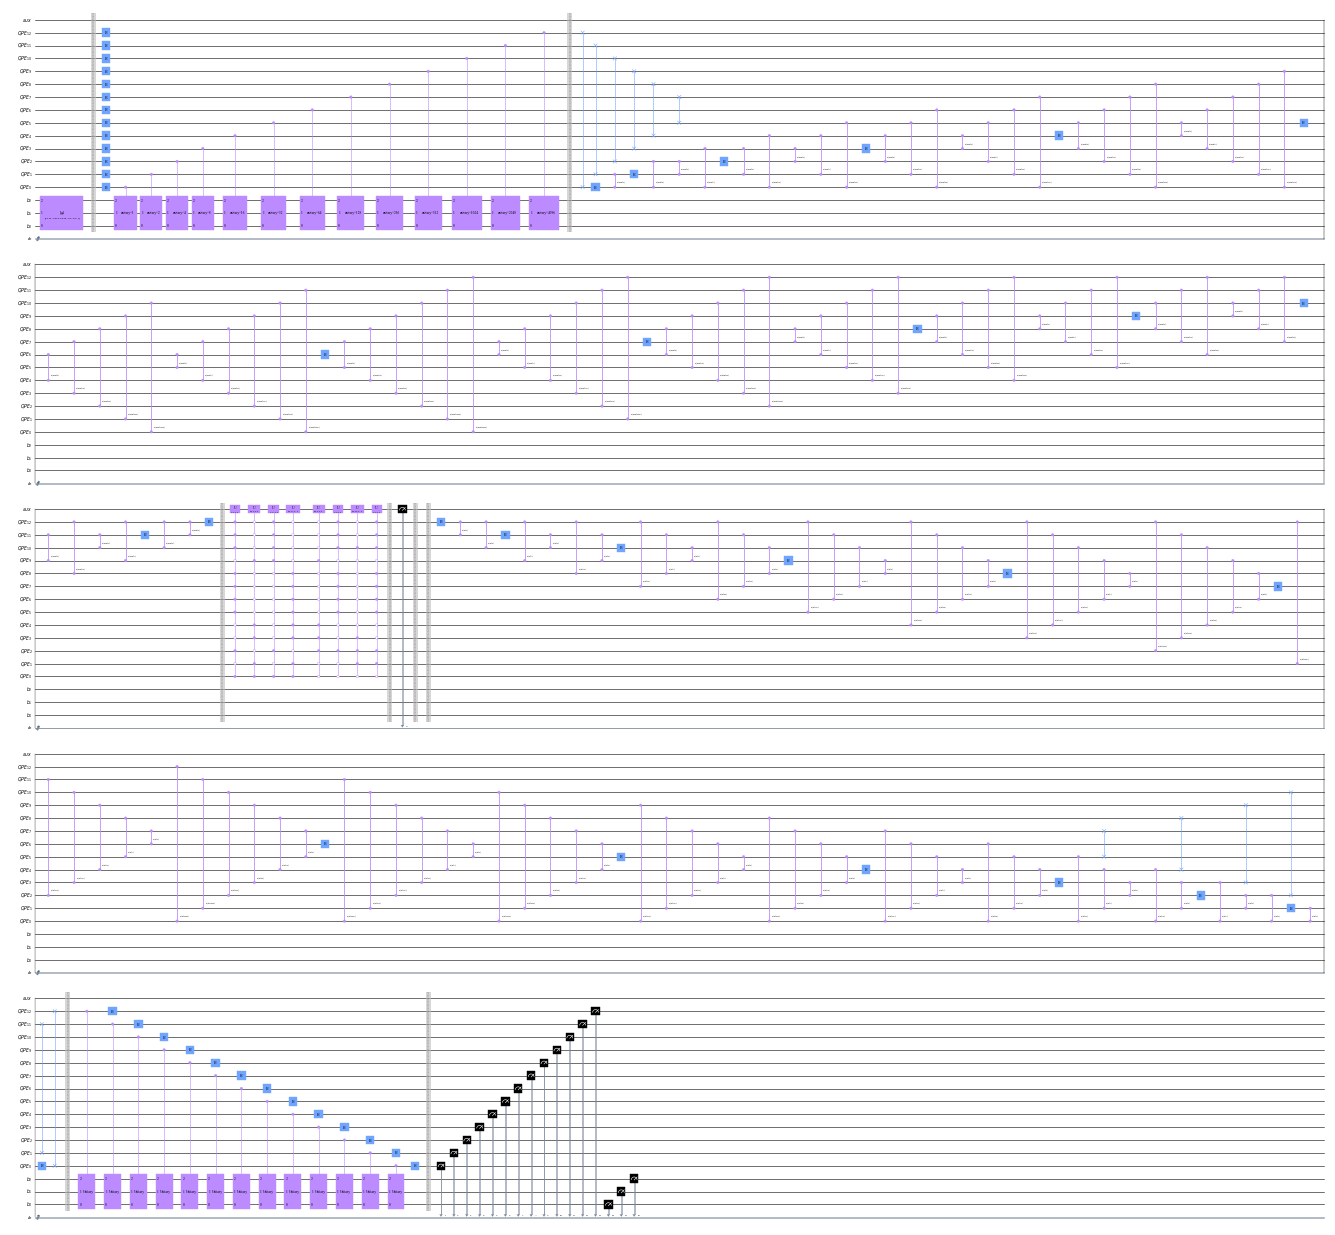

In [946]:
######################################################
############## Hyperparams + Problem #################
######################################################
shots = 2**16 # execution shots

# Try these problem statements out, each with carefully chosen hyperparameters

# A is a 3x3 invertible non hermitian sparse matrix that is well scaled and stable - GOOD EX
tol = 2e-6
ev_time = 150
A = np.matrix([[1, 1, 0],[-1, 1, -1],[0, 0.12, 1.2]])
b = np.array([1, 2, 3])

# A is a 3x3 invertible non hermitian sparse matrix that is well scaled and stable - OKAY EX
# tol = 2e-4
# ev_time = 2*pi
# A = np.matrix([[4/5, 1/5, 0],[0, 3/5, 1/5],[0, 0, 2.9/5]])
# b = np.array([1, 2, 3])

# A is a 2x2 hermitian matrix
# tol = 1e-1
# ev_time = pi
# A = np.matrix([[3/4, 1/4],[1/4, 3/4]])
# b = np.array([0, 1])

# A is a complex 4x4 hermitian matrix
# tol = 1e-4
# ev_time = pi
# A = np.matrix([[4, 1 + 1j, 0, 0],[1 - 1j, 4, 0.5, 0],[0, 0.5, 4, 0.5],[0, 0, 0.5, 4]])
# b = np.array([0, 1, 0, 1])

######################################################
################### HHL Creation #####################
######################################################

A_p, b_p, nq, hhl = hhl_circuit(A, b, tol, ev_time)
hhl.draw('mpl', reverse_bits=True, scale=0.2, fold=100)


The HHL circuit failed 20.93963623046875% of the time.
|x> prob. HHL   : [0.101 0.563 0.335]
|x> prob. actual: [0.181 0.473 0.346]
Normalized Error: 0.12030526615757495


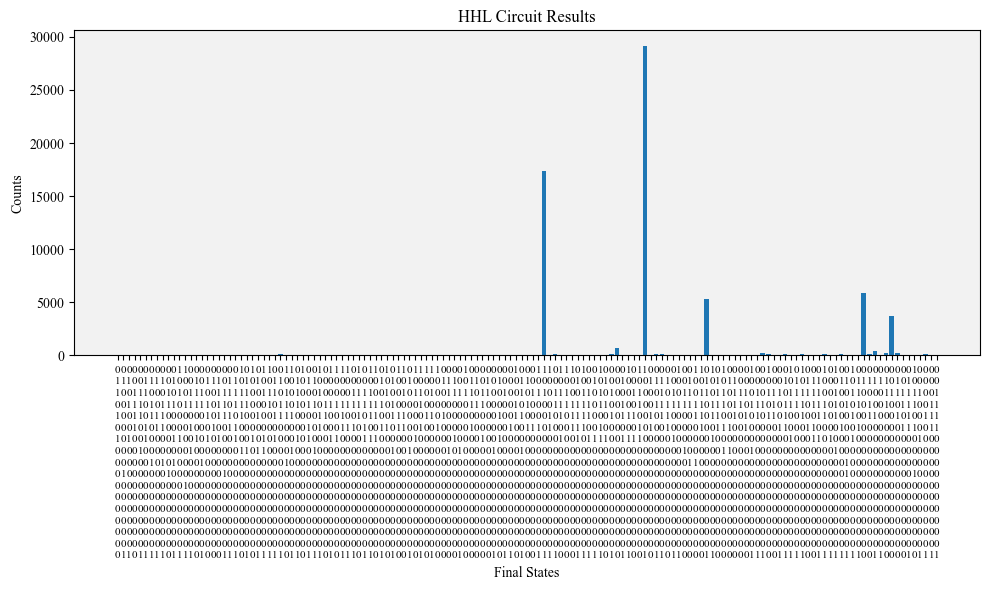

In [947]:
######################################################
##################### Results $$$#####################
######################################################

job = execute(hhl, backend=backend_qasm, shots=shots)
counts = job.result().get_counts()
failed_count, trimmed_counts = remove_fails(counts.copy())

x_HHL = get_x_hhl(shots, failed_count, trimmed_counts, b)
x = get_x_actual(A, b)
print(f"The HHL circuit failed {failed_count/shots*100}% of the time.")
print('|x> prob. HHL   :', np.array2string(x_HHL, formatter={'float_kind': lambda x: f"{x:.3f}"}))
print('|x> prob. actual:', np.array2string(np.real(x), formatter={'float_kind': lambda x: f"{x:.3f}"}))
print('Normalized Error:', np.linalg.norm(x_HHL - x))

# plot_histogram(counts) # qiskit's visualizer

fig, ax = plt.subplots(figsize=(10, 6)) # matplotlib
ax.set_facecolor('#f2f2f2')
keys = list(counts.keys())
values = list(counts.values())
plt.rcParams.update({'font.family': 'Times New Roman'})
ax.bar(keys, values)
ax.tick_params(axis='x', labelsize=8, rotation=0)
ax.set_xticks(range(len(keys)))
keys_formatted = ['\n'.join(list(key)) for key in keys]
ax.set_xticklabels(keys_formatted)
ax.set_xlabel('Final States')
ax.set_ylabel('Counts')
ax.set_title('HHL Circuit Results')

plt.tight_layout()
plt.show()

<div style="font-family: 'Times New Roman'; font-size: 16px;">

From our results, you can see the final states retrieved after executing the circuit for the specified number of shots. It is important to note which shots correspond to success and which correspond to failure (specified in Section 1). The results are displayed with the least significant bit (ancilla bit) displayed at the bottom, followed by the QPE register bits stacked on top, with the last $\log_2(n)$ bits on top.

In addition, you can see the difference between the probability distributions of our $\ket{x}$ from the HHL algorithm, and a generic classical numpy algorithm.

It is important to note that as HHL is quite sensitive to the matrix $A$ itself, the success of the results also depends on the matrix. A good rule of thumb is that high failure rates often indicate inaccurate results. Also, changing the hyperparameters such as evolution time also depend on each matrix. If the two dimensions of $\ket{x}$ mismatch, the circuit failed, run again.

</div>

<div style="font-family: 'Times New Roman'; font-size: 16px;">

### Section 4: Subroutines

The following section will now perform a data fitting algorithm outlined by N. Wiebe, D. Braun, and S. Lloyd [\[DOI\]](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.109.050505#fulltext). HHL is used as a subroutine within this larger data fitting problem, which is broken down into three subroutines: (1) Fitting Psuedoinverse (2) Estimating Fit Quality (3) Learning $\boldsymbol{\lambda}$

<br>

Our problem is defined as minimizing
$$E = |\mathbf{F}\boldsymbol{\lambda} - \mathbf{y}|^2, \quad\text{ such that } \boldsymbol{\lambda} \in \mathbb{C}^N \text{ and } \mathbf{F} \in \mathbb{C}^{N \times M} \text{ and } \mathbf{y} \in \mathbb{C}^{M}$$
by choosing the minimizing fit parameters $\boldsymbol{\lambda}$ (Least squares fitting problem). We also will assume the conditions that $\frac{1}{\kappa^2} \leq \| F^{\dagger} F \| \leq 1$ and $\frac{1}{\kappa^2} \leq \| F F^{\dagger}\| \leq 1$ where $\kappa$ is the condition number of the invertible matrix $\mathbf{F}$ and $\|\cdot\|$ denotes the spectral norm.

Input: A Quantum State: $\ket{y}$, the condition number of $\mathbf{F}$: $\kappa$, the sparseness of $\mathbf{F}$: s, and an error tolerance value: $\epsilon$.

For our purposes, we will solve a data fitting problem where $\mathbf{F} \in \mathbb{R}^{4\times3}$ with rank 3, meaning $M=4, N=3$. In addition, $y \in \mathbb{R}^4$ that is not a linear combination of the columns of F. In addition, note that the Moore-Penrose pseudoinverse of $\mathbf{F}$ is denoted $\mathbf{F}^+$ to $y$ is
$$\boldsymbol{\lambda} = \mathbf{F}^+\mathbf{y} = (\mathbf{F}^\dagger \mathbf{F})^{-1} \mathbf{F}^\dagger \mathbf{y}$$
and will be used to solve the fitting problem.

</div>

In [1002]:
tol = 1e-2
ev_time = pi
shots = 1024
F = np.matrix([[1, 1, 1], [0, 0, 1], [1, 0, 0], [0.5, 1, 0]])
y = np.array([0, 0, 1, 0])

<div style="font-family: 'Times New Roman'; font-size: 16px;">

#### **1. The Pseudoinverse**

Given the general Moore-Penrose pseudoinverse $\lambda = F^+y = (F^\textdagger F)^{-1} F^\textdagger y$, we can reformulate the components to be written as 
$$(F^\textdagger F) \lambda =  F^\textdagger y$$.
This has the same structure as the linear system $Ax = b$, where $A = (F^\textdagger F)$ and $b = F^\textdagger y$. Therefore, we can apply the HHL algorithm to estimate $\lambda$ after some pre-processing of our matrix, vector inputs. As implemented above, HHL can handle non-hermitian matrices by forming the specfied block matrix in section 2.

</div>

In [994]:
def perform_pseudoinverse(
    F: np.ndarray,
    y: np.ndarray,
) -> (np.ndarray, np.ndarray):
    """    
    :param F: A numpy matrix 
    :param y: A numpy vector
    :return: A and b values usable for the hhl algorithm
    """
    F_dag = F.getH()
    A = F_dag @ F
    b = np.dot(F_dag, y.T)
    
    # Note that padding is performed in the preprocessing of our hhl algorithm
    return A, np.asarray(b.flatten())[0]

<div style="font-family: 'Times New Roman'; font-size: 16px;">

#### **2. Estimating Fit Quality**

Estimating the Fit Quality translates to applying the HHL algorithm on A and b for the reasons provided in the article. Ultimately, we can then perform the Swap Test to distinguish $|y⟩$ and $I(F)|\lambda⟩$ controlled by a qubit in the $\ket{+}$ state. If the outcome is 1, we can conclude that the states are different.

Note: $I(\cdot)$ corresponds to making the isometry (same as the block matrix operation in Section 2).
</div>

In [ ]:
def swap_test(y, sol):
    """
    :param y: Numpy array representing |y⟩
    :param quantum_solution: Numpy array representing I(F)|λ⟩
    :return: Probability of measuring 1 and overlap given by sqrt((1 - 2 * p_1))
    """    
    n = int(math.log2(F.shape[0]))
    qc = QuantumCircuit(2*n + 1, 1)

    qc.initialize(y, range(1, n + 1))
    qc.initialize(sol, range(n + 1, 2 * n + 1))
    
    qc.h(0) #Hadamard ancilla

    # Apply SWAP gates
    for i in range(n):
        qc.cswap(0, i+1, i+n+1)

    qc.h(0) # Hadamard ancilla again

    # Measure the ancilla
    qc.measure(0, 0)

    res = execute(qc, simulator, shots=1024).result()
    counts = res.get_counts()
    
    # Prob of 1
    p_1 = counts.get('1', 0) / 1024
    if p_1 <= 0.5:
        overlap = np.sqrt(1 - 2 * p_1)

    return p_1, overlap

In [955]:
import math
def est_fit(
    F: np.ndarray,
    y: np.ndarray,
):
    """    
    :param F: A numpy 4x3 matrix 
    :param y: A numpy 4x1 vector
    :return: Quantum solution, probability of 1, and the overlap
    """
    # Apply subroutine 1
    A, b = perform_pseudoinverse(F, y)
    tol = 1e-1
    ev_time = pi

    # Apply HHL algorithm
    A_p, b_p, nq, hhl = hhl_circuit(A, b, tol, ev_time)
    job = execute(hhl, backend=backend_qasm, shots=shots)
    counts = job.result().get_counts()
    failed_count, trimmed_counts = remove_fails(counts.copy())

    x_HHL = get_x_hhl(shots, failed_count, trimmed_counts, b)
    x = get_x_actual(A, b)

    # Apply Swap test -> where are we getting y and sol from?
    # Is sol supposed to be solution = x_HHL? Can we calculate this in the pseudoinverse step or do we have to wait?
    p_1, overlap = swap_test(x_HHL, x) 
    return sol, p_1, overlap



<div style="font-family: 'Times New Roman'; font-size: 16px;">

#### **3. Learning $\lambda$**

Finally, learning $\lambda$ involves statistical sampling the output of HHL. We want to find a concise representation for the quantum state using 𝑀′ parameters. The first step of the algorithm involves preparing the state |𝝀⟩ using HLL. This state is then measured 𝒪(𝑀′) times, and a histogram of the measurement results is generated. Since the probability of observing each outcome is proportional to its relevance to the fit, sampling the state 𝒪(𝑀′) times will likely yield the 𝑀′ most probable outcomes.

</div>

In [ ]:
def learn_lambda(
    F: np.ndarray,
    y: np.ndarray,
    nShots: int,
):
    c = ClassicalRegister(2, 'c')
    sol, p_1, overlap = est_fit(F, y)
    qc = QuantumCircuit(sol, c)
    qc.measure(range(2), c)

    # Display lambda
    res = execute(qc, backend_qasm, shots=nShots).result() 
    counts = res.get_counts()
    failed_count, trimmed_counts = remove_fails(counts.copy())
    plot_histogram(trimmed_counts)   
    return trimmed_counts

<b> 4. Testing it all together </b>

In [ ]:
# F with rank 3
F = np.matrix([[1, 0, 0],
               [0, 1, 0], 
               [0, 0, 1], 
               [1, 1, 1]])

print("The rank of matrix F is", np.linalg.matrix_rank(F))

# Y (4 x 1) that is not a linear combination of F's columsn
y = np.array([[1],
             [1],
             [1],
             [2]])

learn_lambda(F, y)